# Wide and CNN
Google 에서 발표현 Wide and Deep 을 약간 변형한 형태로 Wide(Logistic)과 Cnn(Deep)을 Combine 형태의 Network 를 개발하였다. <br> 
여기서는 자연어를 Wide and Cnn 을 사용하여 Classification 하는 것을 테스트 하고자 한다. 

In [138]:
import requests
import json, os

nn_id = 'wcnntest8'  # put some key value you want to test

url = "{0}:{1}".format(os.environ['HOSTNAME'] , "8000")
print("done")

done


# 네트워크 및 그래프 버전 생성 


In [139]:
####(1) 네트워크 생성 ####
resp = requests.post('http://' + url + '/api/v1/type/common/target/nninfo/nnid/' + nn_id + '/',
                     json={
                         "biz_cate": "MES",
                         "biz_sub_cate": "M60",
                         "nn_title" : "test",
                         "nn_desc": "test desc",
                         "use_flag" : "Y",
                         "dir": "purpose?",
                         "config": "N"
                     })
data = json.loads(resp.json())
print("evaluation result : {0}".format(data))

####(2) 버전 생성 ####
resp = requests.post('http://' + url + '/api/v1/type/common/target/nninfo/nnid/' + nn_id + '/version/',
                 json={
                     "nn_def_list_info_nn_id": "",
                     "nn_wf_ver_info": "test version info",
                     "condition": "1",
                     "active_flag": "Y"
                 })
data = json.loads(resp.json())
print("evaluation result : {0}".format(data))


evaluation result : wcnntest8
evaluation result : wcnntest8


# 그래프 플로우 정의

In [140]:
# Work Flow 틀을 구성하도로고 지시한다. (정해진 틀을 강제로 생성)
resp = requests.post('http://' + url + '/api/v1/type/wf/target/init/mode/simple/' + nn_id +'/wfver/1/',
                     json={
                         "type": 'wcnn'
                     })
data = json.loads(resp.json())
print("evaluation result : {0}".format(data))

evaluation result : wcnn


# 데이터 업로드

In [141]:
import os

return_dict = {}
return_dict['test'] = open('../../data/seq2seq_several_case.csv', 'rb')

resp = requests.post('http://' + url + '/api/v1/type/wf/state/framedata/src/local/form/raw/prg/source/nnid/'+nn_id+'/ver/1/node/data_node/',
                     files = return_dict)

data = json.loads(resp.json())
print("evaluation result : {0}".format(data))

evaluation result : ['1 file upload success']


# 데이터 노드 정의

In [142]:
# (1) Train Data Node 의 속성을 정의
# 어디서 Source 를 어떻게 가지고 올것인지 파라메터 정의 
resp = requests.put('http://' + url + '/api/v1/type/wf/state/framedata/src/local/form/raw/prg/source/nnid/'+nn_id+'/ver/1/node/data_node/',
                     json={
                         "type": "csv",
                         "source_server": "local",
                         "source_sql": "all",
                     })

# 전처리는 어떤 것을 할지 정의
resp = requests.put('http://' + url + '/api/v1/type/wf/state/framedata/src/local/form/raw/prg/pre/nnid/'+nn_id+'/ver/1/node/data_node/',
                      json={
                          "preprocess":  "none",
                      })
# 전처리가 완료된 데이터는 어디에 저장을 할지 
resp = requests.put('http://' + url + '/api/v1/type/wf/state/framedata/src/local/form/raw/prg/store/nnid/'+nn_id+'/ver/1/node/data_node/',)

data = json.loads(resp.json())
print("evaluation result : {0}".format(data))

evaluation result : /hoya_str_root/wcnntest8/1/data_node


# 데이터 Feeder 정의
 - encode_column : csv file 에서 encode 데이터로 사용할 컬럼명 
 - decode_column : csv file 에서 decode 데이터로 사용할 컬럼명 
 - channel : cnn Neural Net 을 공유하여 사용하기 때문에 Channel 지정 (특별한 경우가 아니면 1 고정) 
 - encode_len : encode 부에서 최대로 인지할 문장 길이 
 - vocab_size : 단어를 Vector 로 Embedding 할때 사용할 embedding Vector size <br>
   (onehot 의 경우 단어 dict size 와 같음) dict 사이즈를 초과하는 단어에 대해서는 Unknown 으로 인지함 
 - char_encode : 음소, 알파뱃 단위로 인코딩을 할 것인지 여부 
 - char_max_len : 음소 단위로 Embedding시 한단어에 포함되는 최대 음소의 길이 
 - lable_size : decode column 에 해당하는 것으로 몇개의 lable 을 사용할 것인지 지정 
 - embed_type : word embedding 을 하기위해서 사용할 embedding 알고리즘 종류 (현재는 onehot만 가능) 

In [143]:
# (2) Network 에 데이터를 Feed하는 Node 의 속성을 정의 
resp = requests.post('http://' + url + '/api/v1/type/wf/state/pre/detail/feed/src/frame/net/wcnn/nnid/'+nn_id+'/ver/1/node/pre_feed_train/',
                     json={
                         "encode_column" : "encode",
                         "decode_column" : "decode",
                         "channel" : 1,
                         "encode_len" : 15,
                         "preprocess": "none",
                         "vocab_size" : 100,
                         "char_encode" : True, 
                         "char_max_len" : 5,
                         "lable_size" : 22, #총 label 수에서 3개 더해야함 
                         "embed_type" : 'onehot'
                     })
data = json.loads(resp.json())
print("evaluation result : {0}".format(data))

evaluation result : {'encode_len': 15, 'encode_column': 'encode', 'vocab_size': 100, 'lable_size': 22, 'preprocess': 'none', 'channel': 1, 'char_max_len': 5, 'char_encode': False, 'decode_column': 'decode', 'embed_type': 'onehot'}


# 네트워크 정의

In [144]:
resp = requests.put('http://' + url + '/api/v1/type/wf/state/netconf/detail/wcnn/nnid/'+nn_id+'/ver/1/node/netconf_node/',
                     json={
                         "param":{"epoch": 1
                                  ,"traincnt": 1
                                  ,"batch_size":64
                                  ,"predictcnt": 10
                         },
                         "config": {"num_classes":22,
                                    "learnrate": 0.001,
                                    "layeroutputs":32,
                                    "net_type":"cnn",
                                    "eval_type":"category",
                                    "optimizer":"AdamOptimizer" #RMSPropOptimizer
                                     }
                         ,"layers": [
                                    {"active": "relu",
                                     "cnnfilter": [3, 3],
                                     "cnnstride": [1, 1],
                                     "maxpoolmatrix": [2, 2],
                                     "maxpoolstride": [2, 2],
                                     "padding": "SAME",
                                     "droprate": "0.5",
                                     "layercnt":2
                                    },
                                    {"active": "relu",
                                     "cnnfilter": [3, 3],
                                     "cnnstride": [1, 1],
                                     "maxpoolmatrix": [1, 1],
                                     "maxpoolstride": [2, 2],
                                     "padding": "SAME",
                                     "droprate": "0.5",
                                     "layercnt":1
                                    }
                                   ]
                         ,"out": {"active": "softmax",
                                   "node_out": 625,
                                   "padding": "SAME"
                                }
                         ,"labels":[]
                        })
data = json.loads(resp.json())
print("evaluation result : {0}".format(data))

evaluation result : {'labels': [], 'param': {'traincnt': 1, 'epoch': 1, 'batch_size': 64, 'predictcnt': 10}, 'out': {'node_out': 625, 'padding': 'SAME', 'active': 'softmax'}, 'config': {'net_type': 'cnn', 'optimizer': 'AdamOptimizer', 'learnrate': 0.001, 'num_classes': 22, 'layeroutputs': 32, 'eval_type': 'category'}, 'model_path': '/hoya_model_root/wcnntest8/1/netconf_node', 'layers': [{'layercnt': 2, 'padding': 'SAME', 'maxpoolmatrix': [2, 2], 'droprate': '0.5', 'maxpoolstride': [2, 2], 'cnnstride': [1, 1], 'cnnfilter': [3, 3], 'active': 'relu'}, {'layercnt': 1, 'padding': 'SAME', 'maxpoolmatrix': [1, 1], 'droprate': '0.5', 'maxpoolstride': [2, 2], 'cnnstride': [1, 1], 'cnnfilter': [3, 3], 'active': 'relu'}]}


# 테스트 프로세스 정의

In [145]:
# upload files for test
return_dict = {}
return_dict['test'] = open('../../data/seq2seq_several_case.csv', 'rb')

resp = requests.post('http://' + url + '/api/v1/type/wf/state/framedata/src/local/form/raw/prg/source/nnid/'+nn_id+'/ver/1/node/test_data_node/',
                     files = return_dict)

data = json.loads(resp.json())
print("evaluation result : {0}".format(data))

# 데이터 - 소스 정의
resp = requests.put('http://' + url + '/api/v1/type/wf/state/framedata/src/local/form/raw/prg/source/nnid/'+nn_id+'/ver/1/node/test_data_node/',
                     json={
                         "type": "csv",
                         "source_server": "local",
                         "source_sql": "all",
                     })
data = json.loads(resp.json())
print("evaluation result : {0}".format(data))

# 데이터 - 전처리 정의
resp = requests.put('http://' + url + '/api/v1/type/wf/state/framedata/src/local/form/raw/prg/pre/nnid/'+nn_id+'/ver/1/node/test_data_node/',
                      json={
                          "preprocess":  "none",
                      })
data = json.loads(resp.json())
print("evaluation result : {0}".format(data))

# 데이터 - 저장 정의
resp = requests.put('http://' + url + '/api/v1/type/wf/state/framedata/src/local/form/raw/prg/store/nnid/'+nn_id+'/ver/1/node/test_data_node/',)

data = json.loads(resp.json())
print("evaluation result : {0}".format(data))


# Feeder 정의
resp = requests.put('http://' + url + '/api/v1/type/wf/state/pre/detail/feed/src/frame/net/wcnn/nnid/'+nn_id+'/ver/1/node/pre_feed_test/',
                     json={
                         "encode_column" : "encode",
                         "decode_column" : "decode",
                         "channel" : 1,
                         "encode_len" : 15,
                         "preprocess": "",
                         "vocab_size" : 100,
                         "char_encode" : True, 
                         "char_max_len" : 5,
                         "embed_type" : 'onehot',
                         "lable_size" : 22
                     })
data = json.loads(resp.json())
print("evaluation result : {0}".format(data))

node_name = 'eval_node'
resp = requests.put('http://' + url + '/api/v1/type/wf/state/eval/nnid/'+nn_id+'/ver/1/node/'+node_name+'/',
                    json={
                        "type": "category",
                    })

data = json.loads(resp.json())
print("evaluation result : {0}".format(data))

evaluation result : ['1 file upload success']
evaluation result : {'type': 'csv', 'multi_node_flag': None, 'source_sql': 'all', 'max_sentence_len': 0, 'source_parse_type': 'raw', 'source_path': '/hoya_src_root/wcnntest8/1/test_data_node', 'predict_path': '/hoya_src_root/wcnntest8/1/predict', 'source_type': 'local', 'source_server': 'local'}
evaluation result : none
evaluation result : /hoya_str_root/wcnntest8/1/test_data_node
evaluation result : {'encode_len': 15, 'encode_column': 'encode', 'vocab_size': 100, 'lable_size': 22, 'preprocess': '', 'channel': 1, 'char_max_len': 5, 'char_encode': False, 'decode_column': 'decode', 'embed_type': 'onehot'}
evaluation result : {'type': 'category'}


# Train

In [146]:
# Run All Workflow
resp = requests.post('http://' + url + '/api/v1/type/runmanager/state/train/nnid/'+nn_id+'/ver/1/')
data = json.loads(resp.json())
print("evaluation result : {0}".format(data))

evaluation result : [None, None, None, None, '', {'predicts': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3], [0, 0, 0, 0, 0

# 시각화

In [147]:
from IPython.display import display, HTML
import pandas as pd

print('http://' + url + '/api/v1/type/result/nnid/' + nn_id + '/ver/1/')
resp = requests.get('http://' + url + '/api/v1/type/result/nnid/' + nn_id + '/ver/1/')
data = json.loads(resp.json())
x= range(len(data.get('labels')))

y = data.get('labels')
y_y = data.get('predicts')

df = pd.DataFrame(y_y)
df.columns = y

HTML(df.to_html())

http://54b714a1ba6f:8000/api/v1/type/result/nnid/wcnntest8/ver/1/


,@,#,UNKNOWN,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,-1
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5


# 시각화

http://54b714a1ba6f:8000/api/v1/type/result/nnid/wcnntest6/ver/1/


<IPython.core.display.Javascript object>


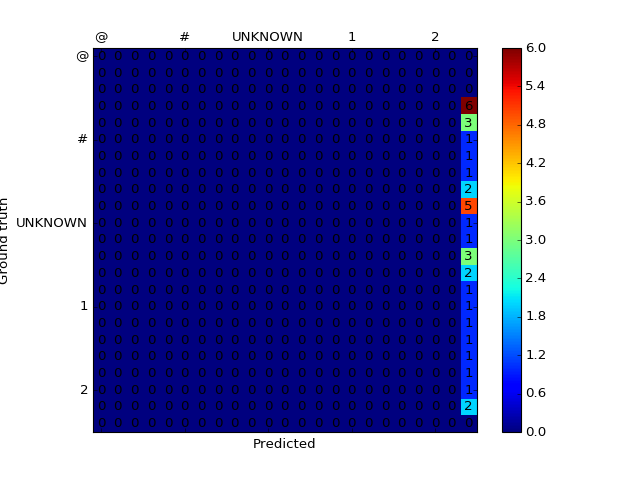

In [125]:
%matplotlib notebook

import matplotlib.pyplot as plt
import numpy as np
import requests
import json, os
import matplotlib.pyplot as plt

print('http://' + url + '/api/v1/type/result/nnid/' + nn_id + '/ver/1/')
resp = requests.get('http://' + url + '/api/v1/type/result/nnid/' + nn_id + '/ver/1/')
data = json.loads(resp.json())

y = data.get('labels')
y_y = data.get('predicts')

df = pd.DataFrame(y_y)
#df = df.transpose()
df.columns = y

labels = y
fig, ax = plt.subplots()
h = ax.matshow(df)
fig.colorbar(h)
for _r in range(len(y)):
    for _c in range(len(y)):
        ax.text(_c, _r, df.values[_r][_c], va='center', ha='center')
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
ax.set_xlabel('Predicted')
ax.set_ylabel('Ground truth')

# Predict

In [92]:
resp = requests.post('http://' + url + '/api/v1/type/service/state/predict/type/wcnn/nnid/'+nn_id+'/ver/active/',
                     json={"input_data" : "[이름] [직급]" }
                     )
data = json.loads(resp.json())
print("evaluation result(1) : {0}".format(data)) 

resp = requests.post('http://' + url + '/api/v1/type/service/state/predict/type/wcnn/nnid/'+nn_id+'/ver/active/',
                     json={"input_data" : "[이름] [직책]" }
                     )
data = json.loads(resp.json())
print("evaluation result(1) : {0}".format(data))

evaluation result(1) : [1]
evaluation result(1) : [1]
evaluation result(1) : [1]
evaluation result(9) : [9]
evaluation result(4) : [4]
evaluation result(11) : [11]
evaluation result(2) : [2]
evaluation result(12) : [12]
evaluation result(2) : ['-1']
evaluation result(2) : ['-1']
evaluation result(7) : [7]
evaluation result(8) : [8]
